## Libraries

In [1]:
import math
from itertools import chain
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score

## Inputs

In [2]:
inputFile = r'burke-gilman-trail-north-of-ne-70th-st-bike-and-ped-counter.csv'  # input file
SEED = 42  # For model
N = 5  # Cross validation

## Import Data

In [3]:
def importData(inputFile):
    # Read File
    df = pd.read_csv(inputFile)

    # Rename Columns
    df = df.rename(columns={'Date': 'date',
                            'BGT North of NE 70th Total': 'total',
                            'Ped South': 'pedSouth',
                            'Ped North': 'pedNorth',
                            'Bike North': 'bikeNorth',
                            'Bike South': 'bikeSouth'})
    
    # Change date to standard date
    df['date'] = df['date'].apply(lambda x: pd.to_datetime(x))
    
    # Sort by date
    df = df.sort_values('date')
       
    # Separate Date
    df.insert(loc=1, column='year', value=df['date'].apply(lambda x: x.year))
    df.insert(loc=2, column='month', value=df['date'].apply(lambda x: x.month))
    df.insert(loc=3, column='day', value=df['date'].apply(lambda x: x.day))
    df.insert(loc=4, column='hour', value=df['date'].apply(lambda x: x.hour))
    
    # Anomaly
    df['anomaly'] = df['total'].apply(lambda x: 1 if x >= 500 else 0)
    return df

df = importData(inputFile)
df.head()

,date,year,month,day,hour,total,pedSouth,pedNorth,bikeNorth,bikeSouth,anomaly
0,2014-01-01 00:00:00,2014,1,1,0,15.0,0.0,2.0,2.0,11.0,0
1,2014-01-01 01:00:00,2014,1,1,1,9.0,1.0,0.0,1.0,7.0,0
2,2014-01-01 02:00:00,2014,1,1,2,9.0,0.0,0.0,0.0,9.0,0
3,2014-01-01 03:00:00,2014,1,1,3,19.0,0.0,0.0,0.0,19.0,0
4,2014-01-01 04:00:00,2014,1,1,4,19.0,0.0,0.0,0.0,19.0,0


## Create  NaN Df
This dataframe will be used later to cross reference test set.  If there are entries in test set with imputed values, those values will be removed from testing.

In [4]:
def getAllNaNs(df):
    df_nan = df[df['total'].isna()]
    return df_nan

df_nan = getAllNaNs(df)
df_nan.head()

,date,year,month,day,hour,total,pedSouth,pedNorth,bikeNorth,bikeSouth,anomaly
5337,2014-08-11 09:00:00,2014,8,11,9,NaN,NaN,NaN,NaN,NaN,0
6586,2014-10-02 10:00:00,2014,10,2,10,NaN,NaN,NaN,NaN,NaN,0
9563,2015-02-03 11:00:00,2015,2,3,11,NaN,NaN,NaN,NaN,NaN,0
10346,2015-03-08 02:00:00,2015,3,8,2,NaN,NaN,NaN,NaN,NaN,0
19250,2016-03-13 02:00:00,2016,3,13,2,NaN,NaN,NaN,NaN,NaN,0


## Create Traffic versus Time Plot
- Yearly seasonality
- Missing values in 2018
- Huge outliers prior to missing values

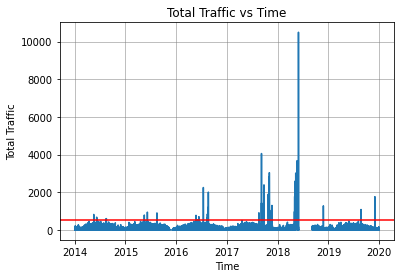

In [5]:
def trafficTimePlot(df):
    # Total traffic vs time
    plt.plot(df['date'], df['total'])
    plt.axhline(y=500, color='r', linestyle='-')
    plt.grid(color='grey', linestyle='-', linewidth=.5)
    plt.xlabel("Time")
    plt.ylabel("Total Traffic")
    plt.title ('Total Traffic vs Time')
    
trafficTimePlot(df)

## Plot histograms
- Increased traffic during the summer seasons
- Increased traffic during the day time, especially around 1600 and 1700

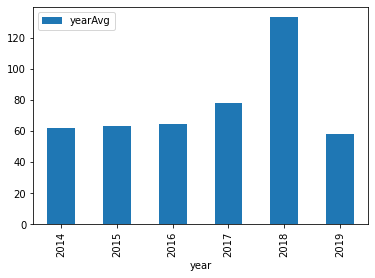

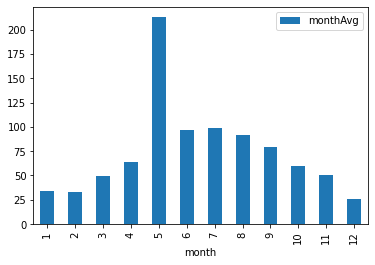

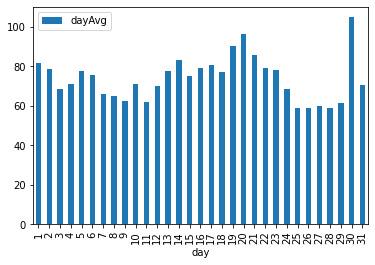

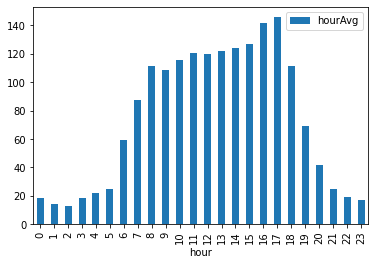

In [6]:
def plotHistograms(df):
    # By year
    df_year = df.groupby('year')['total'].mean().to_frame('yearAvg').reset_index()
    df_year.plot.bar(x='year', y='yearAvg')
    
    # By month
    df_month = df.groupby('month')['total'].mean().to_frame('monthAvg').reset_index()
    df_month.plot.bar(x='month', y='monthAvg')
    
    # By day
    df_day = df.groupby('day')['total'].mean().to_frame('dayAvg').reset_index()
    df_day.plot.bar(x='day', y='dayAvg')
    
    # By hour
    df_hour = df.groupby('hour')['total'].mean().to_frame('hourAvg').reset_index()
    df_hour.plot.bar(x='hour', y='hourAvg')

plotHistograms(df)   

## Month versus Hour Plots
### Plot 1: Total Number of anomalies by month and hour
- May has the most anomalies
- September, October, November have a decent amount of anomalies
- Increased number of anomalies between 0600 and 1500

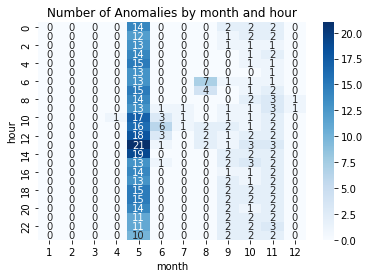

In [7]:
def monthHourPlot1(df):
    # Number of anomalies by month hour
    df_numAnom = df.groupby(['month', 'hour'])['anomaly'].sum().reset_index()
    df_numAnom = df_numAnom.pivot('hour', 'month', 'anomaly')
    ax1 = sns.heatmap(df_numAnom, annot=True, cmap='Blues', fmt="d")    
    ax1.set_title('Number of Anomalies by month and hour')
    
monthHourPlot1(df)

### Plot 2: Mean total for anomalies by month and hour
- Increased total traffic in May
- Increased total traffic from April to September
- Incrased total traffic from 0700 to 1800

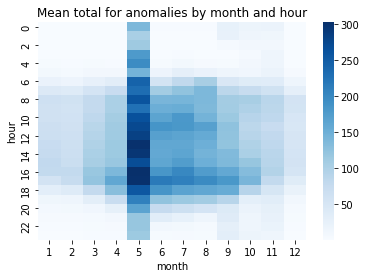

In [8]:
def monthHourPlot2(df):
    df_meanTotal = df.groupby(['month', 'hour'])['total'].mean().reset_index()
    df_meanTotal = df_meanTotal.pivot('hour', 'month', 'total')
    ax1 = sns.heatmap(df_meanTotal, cmap='Blues', fmt="d") 
    ax1.set_title('Mean total for anomalies by month and hour')
    
monthHourPlot2(df)

### Plot 3: Binary view for anomalies by month and hour
- Allows us to see clusters of anomalies

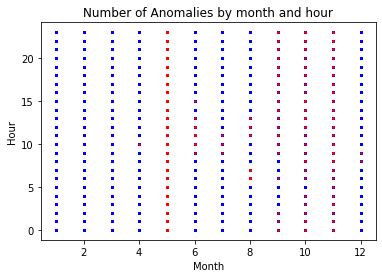

In [9]:
def monthHourPlot3(df):
    df_anom = df[df['anomaly'] == 1]
    df_norm = df[df['anomaly'] == 0]
    plt.scatter(df_norm['month'], df_norm['hour'], c='b', s=2)
    plt.scatter(df_anom['month'], df_anom['hour'], c='r', s=2)
    plt.xlabel("Month")
    plt.ylabel("Hour")
    plt.title ('Number of Anomalies by month and hour')
    
monthHourPlot3(df)

## Outlier Detection using Density Based Spacial Clustering
- Unsupervised ML method for decting outliers
- Create 20 different clusters
- Last cluster has the largest outliers

Really, what I wanted to accomplish here was to remove those huge outliers hovering around 10,000.  Using this method, I reduced any outlier greater than the lowest value in the last cluster (2619) to that lowest value

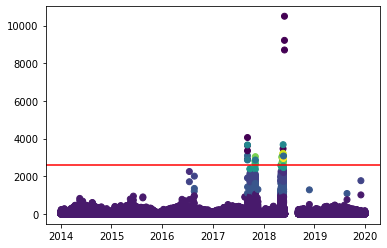

In [10]:
def outlierDetection(df):
    # Get min outlier threshold 
    minOutlierValue = useDBSCAN(df)
    
    # Change values of pedSouth
    df['pedSouth'] = df.apply(lambda row: row['pedSouth'] if row['total'] < minOutlierValue 
                                                          else row['pedSouth'] * minOutlierValue // row['total'], 
                                                          axis=1)
    
    # Change values of pedNorth
    df['pedNorth'] = df.apply(lambda row: row['pedNorth'] if row['total'] < minOutlierValue 
                                                          else row['pedNorth'] * minOutlierValue // row['total'], 
                                                          axis=1)
    
    # Change values of bikeSouth
    df['bikeSouth'] = df.apply(lambda row: row['bikeSouth'] if row['total'] < minOutlierValue 
                                                          else row['bikeSouth'] * minOutlierValue // row['total'], 
                                                          axis=1)
    
    # Change values of bikeNorth
    df['bikeNorth'] = df.apply(lambda row: row['bikeNorth'] if row['total'] < minOutlierValue 
                                                          else row['bikeNorth'] * minOutlierValue // row['total'], 
                                                          axis=1)
    
    # Recalculate the total
    df['total'] = df['pedSouth'] + df['pedNorth'] + df['bikeSouth'] + df['bikeNorth']
    return df
    
# Density Based Spacial Clustering 
def useDBSCAN(df):
    # Convert to np array
    dbValue = df['total'].to_numpy()
    dbDate = df['date'].to_numpy()
    
    # Get rid of NaNs
    notNanIdx = ~np.isnan(dbValue)
    dbValue = dbValue[notNanIdx].reshape(-1,1)
    dbDate = dbDate[notNanIdx].reshape(-1,1)
    
    # Find outliers
    clusters = DBSCAN(eps=20, min_samples=2).fit(dbValue).labels_
    
    # Plot Results
    plt.scatter(dbDate, dbValue, c=clusters)
    
    # Take the group with the highest values
    outliers = dbValue[clusters==-1]

    # Min outlier value
    minOutlierValue = min(outliers)
    minOutlierValue = int(minOutlierValue[0])
    
    # Plot outlier cutoff line
    plt.axhline(y=minOutlierValue, color='r', linestyle='-')
    return minOutlierValue

df = outlierDetection(df)

## Impute missing values
The strategy here is to find the cumulative mean by grouping by year, month, day, hour.  If there is a missing value, then the value will take the cumulative mean value of the previous year, month, day, hour.  If the year is the first year (2014), it will take the value of the previous hour. 

,date,year,month,day,hour,total,pedSouth,pedNorth,bikeNorth,bikeSouth,anomaly,totalCumMean
0,2014-01-01 00:00:00,2014,1,1,0,15.0,0.0,2.0,2.0,11.0,0,15.0
1,2014-01-01 01:00:00,2014,1,1,1,9.0,1.0,0.0,1.0,7.0,0,9.0
2,2014-01-01 02:00:00,2014,1,1,2,9.0,0.0,0.0,0.0,9.0,0,9.0
3,2014-01-01 03:00:00,2014,1,1,3,19.0,0.0,0.0,0.0,19.0,0,19.0
4,2014-01-01 04:00:00,2014,1,1,4,19.0,0.0,0.0,0.0,19.0,0,19.0


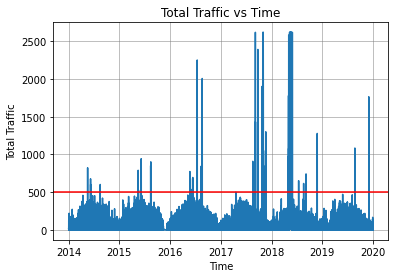

In [11]:
def imputation(df):
    # Create a copy of df to manipulate and append results to df
    df_imp = df.copy(deep=True)
    
    # Cumsum
    df_imp['totalCumsum'] = df_imp.groupby(['month', 'day', 'hour'])['total'].cumsum()
    df_imp['pedSouthCumsum'] = df_imp.groupby(['month', 'day', 'hour'])['pedSouth'].cumsum()
    df_imp['pedNorthCumsum'] = df_imp.groupby(['month', 'day', 'hour'])['pedNorth'].cumsum()
    df_imp['bikeSouthCumsum'] = df_imp.groupby(['month', 'day', 'hour'])['bikeSouth'].cumsum()
    df_imp['bikeNorthCumsum'] = df_imp.groupby(['month', 'day', 'hour'])['bikeNorth'].cumsum()

    # Rank
    df_imp['rank'] = df_imp.groupby(['month', 'day', 'hour'])['year'].rank()
    
    # CumMean
    df_imp['totalCumMean'] = df_imp['totalCumsum'] / df_imp['rank']
    df_imp['pedSouthCumMean'] = df_imp['pedSouthCumsum'] / df_imp['rank']
    df_imp['pedNorthCumMean'] = df_imp['pedNorthCumsum'] / df_imp['rank']
    df_imp['bikeSouthCumMean'] = df_imp['bikeSouthCumsum'] / df_imp['rank']
    df_imp['bikeNorthCumMean'] = df_imp['bikeNorthCumsum'] / df_imp['rank']
    
    # Sort Values by month, day, hour
    df = df.sort_values(['month', 'day', 'hour'])
    df_imp = df_imp.sort_values(['month', 'day', 'hour'])
    
    # Add Total Cumulative Mean to df
    df['totalCumMean'] = df_imp['totalCumMean']
    
    # Impute values
    df = df.apply(lambda row: insertImputedValues(row, df, df_imp), axis=1)
    
    # Sort Values by time
    df = df.sort_values('date')
    return df
     
def insertImputedValues(row, df, df_imp):
    # Define variables
    year = row['year']
    month = row['month']
    day = row['day']
    hour = row['hour']
    total = row['total']
    
    # Return current values if nothing to impute
    if not pd.isnull(total):
        return row
    
    # If year is 2014, return previous hours value
    if year == 2014:
        # Take previous hour sample
        df_temp = df[(df['year'] == year) & (df['month'] == month) & (df['day'] == day) & (df['hour'] == hour-1)]
        
        row['total'] = df_temp['total'].iloc[0]                # total
        row['totalCumMean'] = df_temp['totalCumMean'].iloc[0]  # totalCumMean
        row['pedSouth'] = df_temp['pedSouth'].iloc[0]          # pedSouth
        row['pedNorth'] = df_temp['pedNorth'].iloc[0]          # pedNorth
        row['bikeSouth'] = df_temp['bikeSouth'].iloc[0]        # bikeSouth
        row['bikeNorth'] = df_temp['bikeNorth'].iloc[0]        # bikeNorth
        return row
    
    # Take previous year's value
    df_impTemp = df_imp[(df_imp['year'] == year-1) & (df_imp['month'] == month) & 
                        (df_imp['day'] == day) & (df_imp['hour'] == hour)]
      
    row['total'] = df_impTemp['totalCumMean'].iloc[0]          # total
    row['totalCumMean'] = df_impTemp['totalCumMean'].iloc[0]   # totalCumMean
    row['pedSouth'] = df_impTemp['pedSouthCumMean'].iloc[0]    # pedSouth
    row['pedNorth'] = df_impTemp['pedNorthCumMean'].iloc[0]    # pedNorth
    row['bikeSouth'] = df_impTemp['bikeSouthCumMean'].iloc[0]  # bikeSouth
    row['bikeNorth'] = df_impTemp['bikeNorthCumMean'].iloc[0]  # bikeNorth
    return row

df = imputation(df)

# Plot Traffic vs Time again to see missing values imputed
trafficTimePlot(df)
df.head()

## Month, Hour Cumulative Mean
From our insights gathered from the heat maps, features that will be added will be the cumulative mean of traffic grouped by month and hour

In [12]:
def monthHourCumMean(df):
    # Create a copy of df to manipulate
    df_monthHour = df.copy(deep=True)
    
    # Sort df and df_monthHour
    df = df.sort_values(['month', 'hour'])
    df_monthHour = df_monthHour.sort_values(['month', 'hour'])
    
    # Group by month hour and get cumulative sum of anomaly and total
    df_monthHour['totalCumSum'] = df_monthHour.groupby(['month', 'hour'])['total'].cumsum()
    df_monthHour['anomalyCumSum'] = df_monthHour.groupby(['month', 'hour'])['anomaly'].cumsum()
    
    # Get rank to calculate cumulative means
    df_monthHour['rank'] = df_monthHour.groupby(['month', 'hour'])['year'].rank(method='first')
    
    # Calculate cumulative mean for anomaly and total
    df['monthHourTotalCumMean'] = df_monthHour['totalCumSum'] / df_monthHour['rank']
    df['monthHourAnomalyCumMean'] = df_monthHour['anomalyCumSum'] / df_monthHour['rank']
    
    # Sort df by time
    df = df.sort_values('date')
    return df

df = monthHourCumMean(df)
df.head()

,date,year,month,day,hour,total,pedSouth,pedNorth,bikeNorth,bikeSouth,anomaly,totalCumMean,monthHourTotalCumMean,monthHourAnomalyCumMean
0,2014-01-01 00:00:00,2014,1,1,0,15.0,0.0,2.0,2.0,11.0,0,15.0,15.0,0.0
1,2014-01-01 01:00:00,2014,1,1,1,9.0,1.0,0.0,1.0,7.0,0,9.0,9.0,0.0
2,2014-01-01 02:00:00,2014,1,1,2,9.0,0.0,0.0,0.0,9.0,0,9.0,9.0,0.0
3,2014-01-01 03:00:00,2014,1,1,3,19.0,0.0,0.0,0.0,19.0,0,19.0,19.0,0.0
4,2014-01-01 04:00:00,2014,1,1,4,19.0,0.0,0.0,0.0,19.0,0,19.0,19.0,0.0


## Calculate Lags and future values (y values)
- total traffic lag1
- rate of traffic change from previous lag
- Anomaly lag1 - was there an anomaly in the previous hour
- Anomaly 3 hours into the future (y-value)
- Traffic 3 hours into the future (y-value if using regression)

In [13]:
def getLags(df):
    # Lag total by 1
    df['totalLag1'] = df['total'].shift()
    
    # Get rate of change since last 1
    df['totalRate1'] = df['total'] - df['totalLag1']
    
    # Anomoly lag1
    df['anomalyLag1'] = df['anomaly'].shift()
    
    # Get total future values to use for prediction
    df['anomalyFuture'] = df['anomaly'].shift(-3)
    df['totalFuture'] = df['total'].shift(-3)
    
    # Drop first row and last 3 due to creating nans
    df = df.dropna()
    return df

df = getLags(df)
df.head()

,date,year,month,day,hour,total,pedSouth,pedNorth,bikeNorth,bikeSouth,anomaly,totalCumMean,monthHourTotalCumMean,monthHourAnomalyCumMean,totalLag1,totalRate1,anomalyLag1,anomalyFuture,totalFuture
1,2014-01-01 01:00:00,2014,1,1,1,9.0,1.0,0.0,1.0,7.0,0,9.0,9.0,0.0,15.0,-6.0,0.0,0.0,19.0
2,2014-01-01 02:00:00,2014,1,1,2,9.0,0.0,0.0,0.0,9.0,0,9.0,9.0,0.0,9.0,0.0,0.0,0.0,14.0
3,2014-01-01 03:00:00,2014,1,1,3,19.0,0.0,0.0,0.0,19.0,0,19.0,19.0,0.0,9.0,10.0,0.0,0.0,10.0
4,2014-01-01 04:00:00,2014,1,1,4,19.0,0.0,0.0,0.0,19.0,0,19.0,19.0,0.0,19.0,0.0,0.0,0.0,10.0
5,2014-01-01 05:00:00,2014,1,1,5,14.0,0.0,0.0,0.0,14.0,0,14.0,14.0,0.0,19.0,-5.0,0.0,0.0,27.0


## Transform Time

From heat map insights, we saw that there were clusters of times when an anomaly was more likely to happen.  Since time is cyclical, we use a sin-cos encoding.

In [14]:
def transformTime(df):
    df = sinCosEncoding(df, 'month')  # month
    df = sinCosEncoding(df, 'day')    # day
    df = sinCosEncoding(df, 'hour')   # hour
    return df

# Sin Cos Encoding for time
def sinCosEncoding(df, column):
    max_value = df[column].max()
    df[column + '_cos'] = df[column].apply(lambda x: math.cos((2 * math.pi * x) / max_value))
    df[column + '_sin'] = df[column].apply(lambda x: math.sin((2 * math.pi * x) / max_value))
    return df

df = transformTime(df)
df.head()

,date,year,month,day,hour,total,pedSouth,pedNorth,bikeNorth,bikeSouth,...,totalRate1,anomalyLag1,anomalyFuture,totalFuture,month_cos,month_sin,day_cos,day_sin,hour_cos,hour_sin
1,2014-01-01 01:00:00,2014,1,1,1,9.0,1.0,0.0,1.0,7.0,...,-6.0,0.0,0.0,19.0,0.866025,0.5,0.97953,0.201299,0.962917,0.269797
2,2014-01-01 02:00:00,2014,1,1,2,9.0,0.0,0.0,0.0,9.0,...,0.0,0.0,0.0,14.0,0.866025,0.5,0.97953,0.201299,0.854419,0.519584
3,2014-01-01 03:00:00,2014,1,1,3,19.0,0.0,0.0,0.0,19.0,...,10.0,0.0,0.0,10.0,0.866025,0.5,0.97953,0.201299,0.682553,0.730836
4,2014-01-01 04:00:00,2014,1,1,4,19.0,0.0,0.0,0.0,19.0,...,0.0,0.0,0.0,10.0,0.866025,0.5,0.97953,0.201299,0.460065,0.887885
5,2014-01-01 05:00:00,2014,1,1,5,14.0,0.0,0.0,0.0,14.0,...,-5.0,0.0,0.0,27.0,0.866025,0.5,0.97953,0.201299,0.203456,0.979084


## Reduce columns to only those needed for model

In [15]:
def getColumnsForModel(df):
    df_model = df[['month_cos', 'month_sin', 
                   'day_cos', 'day_sin',
                   'hour_cos', 'hour_sin', 
                   'total', 'totalCumMean', 'totalLag1', 'totalRate1',
                   'monthHourTotalCumMean',
                   'anomaly', 'anomalyLag1',
                   'monthHourAnomalyCumMean',
                   'anomalyFuture']]
    return df_model

df_model = getColumnsForModel(df)
df_model.head()

,month_cos,month_sin,day_cos,day_sin,hour_cos,hour_sin,total,totalCumMean,totalLag1,totalRate1,monthHourTotalCumMean,anomaly,anomalyLag1,monthHourAnomalyCumMean,anomalyFuture
1,0.866025,0.5,0.97953,0.201299,0.962917,0.269797,9.0,9.0,15.0,-6.0,9.0,0,0.0,0.0,0.0
2,0.866025,0.5,0.97953,0.201299,0.854419,0.519584,9.0,9.0,9.0,0.0,9.0,0,0.0,0.0,0.0
3,0.866025,0.5,0.97953,0.201299,0.682553,0.730836,19.0,19.0,9.0,10.0,19.0,0,0.0,0.0,0.0
4,0.866025,0.5,0.97953,0.201299,0.460065,0.887885,19.0,19.0,19.0,0.0,19.0,0,0.0,0.0,0.0
5,0.866025,0.5,0.97953,0.201299,0.203456,0.979084,14.0,14.0,19.0,-5.0,14.0,0,0.0,0.0,0.0


## Use a Standard Scalar to scale numeric features

In [16]:
def scaleFeatures(df_model):
    # Create a df of numeric features to scale
    df_num = df_model[['total', 'totalCumMean', 'totalLag1', 'totalRate1', 
                       'monthHourTotalCumMean','monthHourAnomalyCumMean']]
    
    # Drop numeric features from df_model
    df_model = df_model.drop(['total', 'totalCumMean', 'totalLag1', 'totalRate1', 
                              'monthHourTotalCumMean','monthHourAnomalyCumMean'], axis=1)
    
    # Scale numeric features
    scaledFeatures = StandardScaler().fit_transform(df_num)
    df_scaled = pd.DataFrame(scaledFeatures, index=df_num.index, columns=df_num.columns)
    
    # Horizontally concatenate 
    df_model = pd.concat([df_model, df_scaled], axis=1)

    # Reorganize order
    df_model = getColumnsForModel(df_model)
    return df_model

df_model = scaleFeatures(df_model)
df_model.head()

,month_cos,month_sin,day_cos,day_sin,hour_cos,hour_sin,total,totalCumMean,totalLag1,totalRate1,monthHourTotalCumMean,anomaly,anomalyLag1,monthHourAnomalyCumMean,anomalyFuture
1,0.866025,0.5,0.97953,0.201299,0.962917,0.269797,-0.383028,-0.713989,-0.347867,-0.072298,-0.879312,0,0.0,-0.297959,0.0
2,0.866025,0.5,0.97953,0.201299,0.854419,0.519584,-0.383028,-0.713989,-0.383029,0.000003,-0.879312,0,0.0,-0.297959,0.0
3,0.866025,0.5,0.97953,0.201299,0.682553,0.730836,-0.324423,-0.591070,-0.383029,0.120504,-0.728744,0,0.0,-0.297959,0.0
4,0.866025,0.5,0.97953,0.201299,0.460065,0.887885,-0.324423,-0.591070,-0.324425,0.000003,-0.728744,0,0.0,-0.297959,0.0
5,0.866025,0.5,0.97953,0.201299,0.203456,0.979084,-0.353725,-0.652530,-0.324425,-0.060248,-0.804028,0,0.0,-0.297959,0.0


## Define X and y values and split data into training and test sets

In [17]:
def defineXandy(df_model):
    # Use last 27% for testing.  This gives 110 anomalies in test set and 386 in training
    testStartIdx = getTestStartIdx(df_model)
    
    # Train and test
    df_train = df_model.iloc[:testStartIdx]
    df_test = df_model.iloc[testStartIdx:]
    
    # Define X
    X_train = df_train.drop(columns='anomalyFuture').to_numpy()
    X_test = df_test.drop(columns='anomalyFuture').to_numpy()

    # Define y
    y_train = df_train['anomalyFuture'].values
    y_test = df_test['anomalyFuture'].values
    return df_train, df_test, X_train, X_test, y_train, y_test

# Get testStartIdx
def getTestStartIdx(df_model):
    # Use last 27% for testing.  This gives 110 anomalies in test set and 386 in training
    testStartIdx = int(len(df_model) - (len(df_model) * .27))
    return testStartIdx

df_train, df_test, X_train, X_test, y_train, y_test = defineXandy(df_model)

## Use Random Forest Classification model

In [18]:
def createModel(SEED):
    model = RandomForestClassifier(criterion='gini',
                                   n_estimators=1750,
                                   max_depth=7,
                                   min_samples_split=6,
                                   min_samples_leaf=6,
                                   max_features='auto',
                                   oob_score=True,
                                   random_state=SEED,
                                   n_jobs=-1,
                                   verbose=1)
    return model

model = createModel(SEED)

## Evaluate Model
- Use stratified k-fold cross validation to balance data sets
- Average OOB score is 0.99 (almost seems to good to be true)

In [19]:
def evaluateModel(model, df_train, X_train, y_train, X_test, N):
    # Out of bag score to predict accuracy of testing set
    oob = 0
    
    # Give probability of survival
    df_pred = pd.DataFrame(np.zeros((len(X_test), N * 2)), 
                           columns=['Fold_{}_Prob_{}'.format(i, j) for i in range(1, N + 1) for j in range(2)])
    
    # Dataframe to keep track of fprs, tprs, trnAucScore, and valAucScore
    df_roc = pd.DataFrame()
    
    # Feature Importance
    columns = list(df_train.columns)
    columns.remove('anomalyFuture')
    df_featImp = pd.DataFrame(np.zeros((X_train.shape[1], N)), 
                              columns=['Fold_{}'.format(i) for i in range(1, N + 1)], 
                              index=columns)
    
    # Stratified crossfold validation
    skf = StratifiedKFold(n_splits=N, random_state=N, shuffle=True)
    for fold, (trnIdx, valIdx) in enumerate(skf.split(X_train, y_train), 1):
        print('Fold {}\n'.format(fold))
        
        # Fitting the model
        model.fit(X_train[trnIdx], y_train[trnIdx])
        
        # Compute oob score
        oob += model.oob_score_ / N
        print('Fold {} OOB Score: {}\n'.format(fold, model.oob_score_))   
        
        # Computing AUC score
        df_roc = getROCCurveValues(model, X_train, y_train, trnIdx, valIdx, df_roc)
        
        # Get Prediction Probabilities
        df_pred = getPredProb(model, fold, df_pred, X_test)
        
        # Feature Importance
        df_featImp = getFeatImp(model, df_featImp, fold)
        
    print('Average OOB Score: {}'.format(oob))
    return df_pred, df_roc, df_featImp, oob

# ROC Curve Values
def getROCCurveValues(model, X_train, y_train, trnIdx, valIdx, df_roc):    
    # Train
    trnFpr, trnTpr, trnThresholds = roc_curve(y_train[trnIdx], model.predict_proba(X_train[trnIdx])[:, 1])
    trnAucScore = auc(trnFpr, trnTpr)
    
    # Validation
    valFpr, valTpr, valThresholds = roc_curve(y_train[valIdx], model.predict_proba(X_train[valIdx])[:, 1])
    valAucScore = auc(valFpr, valTpr)
    
    # Append Scores
    df_rocTemp = pd.DataFrame({'fprs': [valFpr], 
                               'tprs': [valTpr], 
                               'trnAucScore': [trnAucScore], 
                               'valAucScore': [valAucScore]})
    df_roc = pd.concat([df_roc, df_rocTemp])
    return df_roc

# Get Prediction Probabilities
def getPredProb(model, fold, df_pred, X_test):
    # X_test probabilities
    df_pred.loc[:, 'Fold_{}_Prob_0'.format(fold)] = model.predict_proba(X_test)[:, 0]
    df_pred.loc[:, 'Fold_{}_Prob_1'.format(fold)] = model.predict_proba(X_test)[:, 1]
    return df_pred

# Feature Importance
def getFeatImp(model, df_featImp, fold):
    df_featImp.iloc[:, fold - 1] = model.feature_importances_
    return df_featImp

df_pred, df_roc, df_featImp, oob = evaluateModel(model, df_train, X_train, y_train, X_test, N)

Fold 1



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 1750 out of 1750 | elapsed:    3.5s finished


Fold 1 OOB Score: 0.9934214811437504



[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 1218 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 1750 out of 1750 | elapsed:    0.6s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 1218 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 1750 out of 1750 | elapsed:    0.5s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concur

Fold 2



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 1750 out of 1750 | elapsed:    3.7s finished


Fold 2 OOB Score: 0.9934540480687813



[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 1218 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 1750 out of 1750 | elapsed:    0.5s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 1218 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 1750 out of 1750 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concur

Fold 3



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 1750 out of 1750 | elapsed:    3.5s finished


Fold 3 OOB Score: 0.9935191819188433



[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 1218 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 1750 out of 1750 | elapsed:    0.6s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 1218 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 1750 out of 1750 | elapsed:    0.5s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concur

Fold 4



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 1750 out of 1750 | elapsed:    3.7s finished


Fold 4 OOB Score: 0.9934216953789038



[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 1218 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 1750 out of 1750 | elapsed:    0.6s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 1218 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 1750 out of 1750 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concur

Fold 5



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 1750 out of 1750 | elapsed:    3.6s finished


Fold 5 OOB Score: 0.9934542612433647



[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 1218 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 1750 out of 1750 | elapsed:    0.6s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 1218 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 1750 out of 1750 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concur

Average OOB Score: 0.9934541335507288


[Parallel(n_jobs=16)]: Done 1750 out of 1750 | elapsed:    0.5s finished


## Plot of Feature Importance

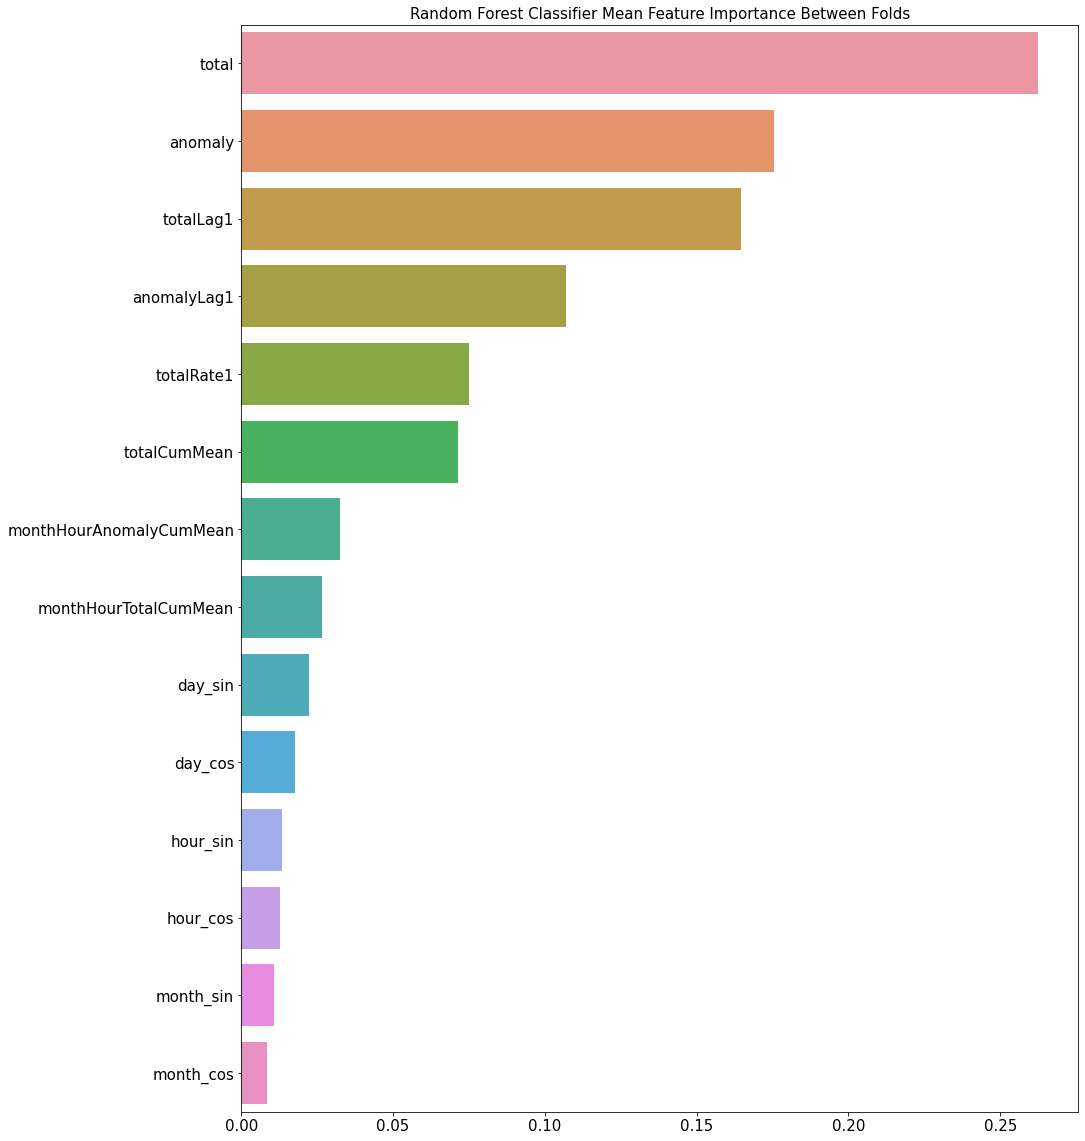

In [20]:
def plotFeatImp(df_featImp):
    df_featImp['Mean_Importance'] = df_featImp.mean(axis=1)
    df_featImp.sort_values(by='Mean_Importance', inplace=True, ascending=False)
    
    plt.figure(figsize=(15, 20))
    sns.barplot(x='Mean_Importance', y=df_featImp.index, data=df_featImp)
    
    plt.xlabel('')
    plt.tick_params(axis='x', labelsize=15)
    plt.tick_params(axis='y', labelsize=15)
    plt.title('Random Forest Classifier Mean Feature Importance Between Folds', size=15)
    
    plt.show()
    
plotFeatImp(df_featImp)

## Plot of ROC Curve

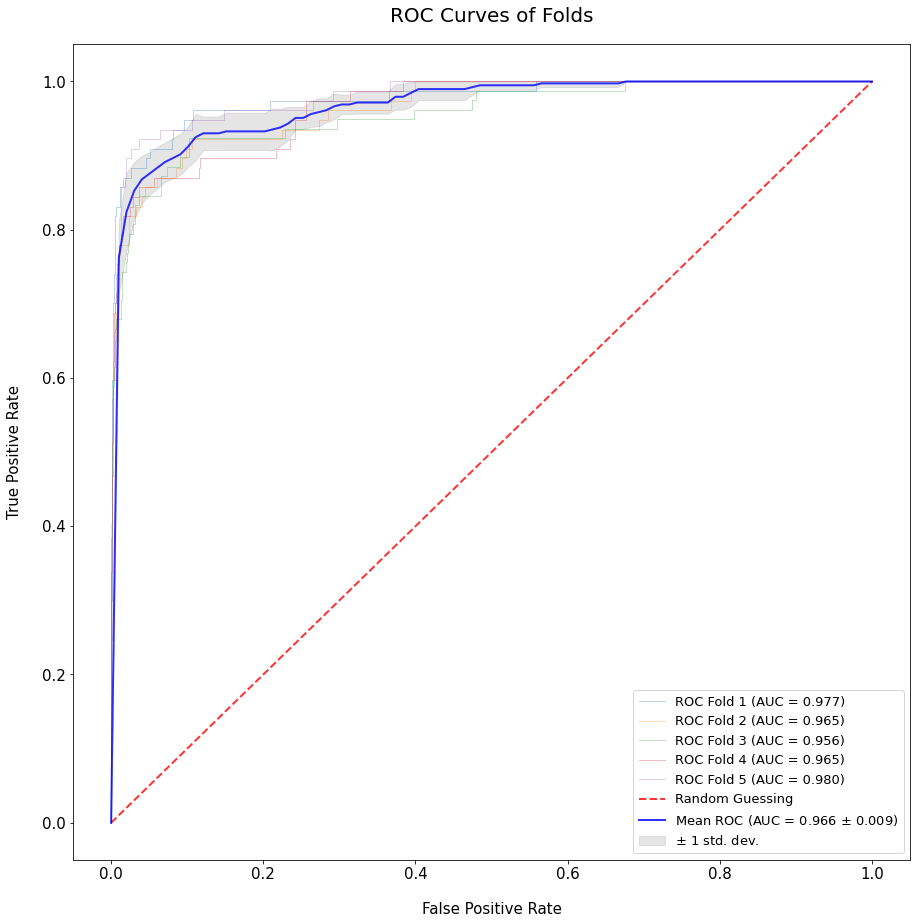

In [26]:
def plot_roc_curve(df_roc):
    # Define fprs and tprs
    fprs = list(df_roc['fprs'])
    tprs = list(df_roc['tprs'])
    
    tprs_interp = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    f, ax = plt.subplots(figsize=(15, 15))
    
    # Plotting ROC for each fold and computing AUC scores
    for i, (fpr, tpr) in enumerate(zip(fprs, tprs), 1):
        tprs_interp.append(np.interp(mean_fpr, fpr, tpr))
        tprs_interp[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        ax.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC Fold {} (AUC = {:.3f})'.format(i, roc_auc))
        
    # Plotting ROC for random guessing
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=0.8, label='Random Guessing')
    
    mean_tpr = np.mean(tprs_interp, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    
    # Plotting the mean ROC
    ax.plot(mean_fpr, mean_tpr, color='b', label='Mean ROC (AUC = {:.3f} $\pm$ {:.3f})'.format(mean_auc, std_auc), 
            lw=2, alpha=0.8)
    
    # Plotting the standard deviation around the mean ROC Curve
    std_tpr = np.std(tprs_interp, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2, label='$\pm$ 1 std. dev.')
    
    ax.set_xlabel('False Positive Rate', size=15, labelpad=20)
    ax.set_ylabel('True Positive Rate', size=15, labelpad=20)
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])

    ax.set_title('ROC Curves of Folds', size=20, y=1.02)
    ax.legend(loc='lower right', prop={'size': 13})
    
    plt.show()
    
plot_roc_curve(df_roc)

## Make Prediction on testing data

In [33]:
def makePrediction(model, df_pred, df, y_test, N):
    # Class anomaly are columns that end with Prob_1
    class_anomaly = [col for col in df_pred.columns if col.endswith('Prob_1')]
    
    # Average anomaly and not anomaly classes
    df_pred['1'] = df_pred[class_anomaly].sum(axis=1) / N
    df_pred['0'] = df_pred.drop(columns=class_anomaly).sum(axis=1) / N
    
    # Initiate prediction column
    df_pred['pred'] = 0
    
    # Get indices of anomaly and set pred = 1 if anomaly
    pos = df_pred[df_pred['1'] >= 0.5].index
    df_pred.loc[pos, 'pred'] = 1
    
    # Predictions
    y_pred = df_pred['pred'].astype(int)
    
    # Get test set
    testStartIdx = getTestStartIdx(df)
    df_test = df[testStartIdx:]
    
    # Create submissions df with date and anomaly
    df_submission = pd.DataFrame()
    df_submission['date'] = df_test['date']
    df_submission['Predicted'] = y_pred.values
    df_submission['Actual'] = y_test
    
    # Count how many correct
    df_submission['Correct'] = df_submission.apply(lambda row: 1 if row['Predicted'] == row['Actual'] else 0, axis=1)
    
    # Ensure submission not based on imputed anomolies
    df_submission = df_submission[~df_submission['date'].isin(list(df_nan['date']))]
    
    # Calculate Metrics
    accuracy = accuracy_score(df_submission['Actual'], df_submission['Predicted'])    # Accuracy
    precision = precision_score(df_submission['Actual'], df_submission['Predicted'])  # precision
    recall = recall_score(df_submission['Actual'], df_submission['Predicted'])        # recall
    f1 = f1_score(df_submission['Actual'], df_submission['Predicted'])                # f1
    return df_submission, accuracy, precision, recall, f1

df_submission, accuracy, precision, recall, f1 = makePrediction(model, df_pred, df, y_test, N)
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1:', f1)

Accuracy: 0.998230684977673
Precision: 0.9405940594059405
Recall: 0.8636363636363636
F1: 0.9004739336492891


## Results
Overall these results look really good.  A business owner can view this analysis and determine that the best time to open up shop is during the summer in the day time.  Because these results can predict the traffic three hours into the future, they can know when to open up and close shop.  It is also important for them not to miss a single critical day.  For example, we saw that the month of May had many anomolies over the years.  May could drive most of the revenue for the entire year.  

## Future steps
- The performance of this model is suspiciously good.  I would definitely want to do further testing to make sure that the results are accurate.  
- I really wanted to see if there was any correlation between north and south traffic.  I really thought that I could find a lag that would indicate returning travelers.  
- I would like to try regression on the total number of travelers, rather than a binary classification on anomalies.  I feel like there is information lost when doing classification.  
- I would also like to try a SARIMA model